## **CS:345 Multilingual Emotion Detection in Social Media**

### **Team Members**
1. Abeeb Abdullahi Samuel
2. Maereg Habtezgi 

### **Introduction**

Social media platforms like Twitter generate vast volumes of short texts that convey a wide spectrum of emotions. This project aims to build an automated system for emotion detection in these posts by fine-tuning transformer-based language models—such as BERT-base-multilingual-cased and XLM-RoBERTa-base—on two Twitter-sourced datasets. We will evaluate which model–dataset combination best captures the subtle nuances of emotional expression, addresses challenges like data imbalance and linguistic variability, and can serve as the foundation for future emotion-classification tasks.

- **BERT (Bidirectional Encoder Representations from Transformers)**
- **XLM-RoBERTa (Cross-lingual Language Model)**

The datasets used for training and evaluation are:

- [`TweetEval`](https://huggingface.co/datasets/cardiffnlp/tweet_eval): A benchmark suite of tasks built on English tweets.
- [`SuperTweetEval`](https://huggingface.co/datasets/cardiffnlp/super_tweeteval): An extended multilingual version supporting more complex evaluation, including multi-label emotion classification.


> **Note:** We have excluded the SEMEVAL-11 dataset from our experiments and are using only the two current Twitter-sourced datasets for the following reasons:
> 1. **Richer annotations:** The two chosen datasets provide more granular emotion categories, clearer label definitions, and additional metadata columns compared to SEMEVAL-11.  
> 2. **Availability:** SEMEVAL-11 is no longer hosted on the Hugging Face platform and cannot be accessed for fine-tuning.




Our aim is to adapt these models to accurately classify a range of emotions datasest found in tweets, evaluating their strengths and challenges during fine-tuning. And see which model perfroms best with which result.

---

### **Project Structure**

This project is divided into **three Jupyter notebooks** for clarity and modular experimentation:

#### 1. `BERT_Finetune.ipynb`

This notebook focuses on:

- Fine-tuning the BERT-based model (including `bert-base-uncased`, `twitter-roberta-base` and its variants) on both TweetEval and SuperTweetEval .
- Preprocessing steps like emoji normalization and tokenization tailored for social media content.
- Handling class imbalance and improving performance through parameter tuning.
- Tracking training/validation metrics and analyzing results across epochs.

#### 2. `XLM_Finetune.ipynb`

This notebook covers:

- Fine-tuning the multilingual `XLM-RoBERTa` model on both TweetEval and SuperTweetEval.
- Addressing challenges in cross-lingual emotion classification.
- Analyzing model performance on non-English tweets.
- Comparative metrics and evaluation of zero-shot or low-resource performance.

#### 3. `Conclusion.ipynb`

This notebook provides:

- A summary of findings from both BERT and XLM fine-tuning experiments.
- A comparative analysis of accuracy and F1 performance across both datasets.
- Key challenges, trade-offs, and recommendations for future work (e.g., better handling of multi-label classification, cross-lingual transfer learning, or low-resource language support).

----

### **Section 1: Finetuning BERT with TweetEval**

In this section, we fine-tune a BERT-based model on the **`TweetEval`** dataset, specifically the **emotion classification** task. This dataset comprises short texts (tweets) labeled with a single emotion class, making it a **single-label classification problem**.

#### Dataset Overview

The **TweetEval: Emotion** configuration contains tweets annotated with one of **four emotion categories**, each mapped to an integer label:

| Label | Emotion   |
|-------|-----------|
| 0     | Anger     |
| 1     | Joy       |
| 2     | Optimism  |
| 3     | Sadness   |

Each training example consists of:
- `text` — the tweet in plain text.
- `label` — an integer representing the emotion class.

**Example entry:**
```json
{
  "text": "Feeling amazing after that workout",
  "label": 1  // Joy
}
```

We first loaded the dataset and inspect the emotion label mapping. We loaded and printed the data using the following code:

In [213]:
import os
from datasets import load_dataset
os.environ["HF_USE_SYMLINKS"] = "0"

raw_datasets = load_dataset("cardiffnlp/tweet_eval", "emotion")

print(raw_datasets)
label_names = raw_datasets["train"].features["label"].names
print("Label mapping:", dict(enumerate(label_names)))

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3257
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1421
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 374
    })
})
Label mapping: {0: 'anger', 1: 'joy', 2: 'optimism', 3: 'sadness'}



### **Model Selection**

We started with **`bert-base-uncased`** as a baseline model before switching to **`vinai/bertweet-base`**, a RoBERTa variant pre-trained on Twitter data and fine-tuned for emotion classification.

To prepare the data, we use the model-specific tokenizer to convert tweets into token IDs, applying truncation (to a max length of 128) and dynamic padding.

The classification model is initialized with the correct number of emotion labels and moved to GPU if available.

In [216]:

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)
import torch

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(
        example["text"],
        truncation=True,
        max_length=128
    )

tokenized_datasets = raw_datasets.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"]
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,            
    num_labels=len(label_names), 
    output_attentions=False,     
    output_hidden_states=False    
)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e


###  **Training Process**

We fine-tuned the model using the Hugging Face `Trainer` API with the following configuration:
- **Epochs:** We started with 3 initially, to avoid overfitting extended to 5 based on performance trends.
- **Learning Rate & Weight Decay:** We chose a 1e-5 learning rate to take smaller, steadier steps into flatter minima, and a 0.05 weight decay to penalize large weights that overfit noise.
- **Loss Function:** Cross-entropy (as this is a single-label task).
- **Metrics:** Accuracy and F1-score (weighted).
- **Evaluation Strategy:** Per epoch with validation loss tracking.
Key elements of the training setup include defining training arguments, specifying evaluation metrics, and training the model:

In [217]:
import evaluate
training_args = TrainingArguments(
    output_dir="./bert-emotion",        
    evaluation_strategy="epoch",       
    save_strategy="epoch",                               
    learning_rate=1e-5,
    per_device_train_batch_size=16,       
    per_device_eval_batch_size=32,        
    num_train_epochs=3,                   
    weight_decay=0.05,                    
    logging_dir="./logs",              
    logging_steps=100,                    
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"    
)

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="weighted")["f1"]
    }


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

C:\Users\samabdul\AppData\Local\Temp\ipykernel_16344\4267084588.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [218]:
print("\nStarting Model Training")
trainer.train()


Starting Model Training


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.895100,0.693198,0.770053,0.745280
2,0.622500,0.594107,0.796791,0.789005
3,0.436900,0.579511,0.804813,0.800647


TrainOutput(global_step=612, training_loss=0.7103180293164222, metrics={'train_runtime': 1439.6991, 'train_samples_per_second': 6.787, 'train_steps_per_second': 0.425, 'total_flos': 210459220706280.0, 'train_loss': 0.7103180293164222, 'epoch': 3.0})

In [220]:
predictions = trainer.predict(tokenized_datasets["test"])

test_metrics = compute_metrics((predictions.predictions, predictions.label_ids))

print("\n Test Set Evaluation Metrics")
print(f" Accuracy: {test_metrics['accuracy']:.4f}")
print(f" F1-Score (Weighted): {test_metrics['f1']:.4f}")



 Test Set Evaluation Metrics
 Accuracy: 0.7966
 F1-Score (Weighted): 0.7917


### **Training Continuation with Enhanced Regularization**
After the first training, the model is now learning real patterns instead of memorizing, but we re not yet maximizing capacity because the training loss is still relatively high (0.437), and test accuracy (0.7966) sits mostly below 0.8 so we:
- increased the **Epochs** to 5 to give the model more epochs under the new regimen.
- **Linear Scheduler & Warmup** we briefly ramp up the LR for stability, then decay it each step.
- **Resume from Checkpoint**  Then retrain the model exactly where we left off.


In [221]:
training_args.num_train_epochs = 5
training_args.save_strategy = "epoch"
training_args.lr_scheduler_type = "linear"
training_args.warmup_steps = 100

trainer_extended = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer_extended.train(resume_from_checkpoint="./bert-emotion/checkpoint-612")


C:\Users\samabdul\AppData\Local\Temp\ipykernel_16344\3760851411.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_extended = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
4,0.401200,0.573323,0.802139,0.798569
5,0.347600,0.583006,0.802139,0.798675


TrainOutput(global_step=1020, training_loss=0.14953667556538303, metrics={'train_runtime': 984.026, 'train_samples_per_second': 16.549, 'train_steps_per_second': 1.037, 'total_flos': 350898810026544.0, 'train_loss': 0.14953667556538303, 'epoch': 5.0})

In [240]:
predictions = trainer.predict(tokenized_datasets["test"])

test_metrics = compute_metrics((predictions.predictions, predictions.label_ids))

print("\n Test Set Evaluation Metrics")
print(f" Accuracy: {test_metrics['accuracy']:.4f}")
print(f" F1-Score (Weighted): {test_metrics['f1']:.4f}")



 Test Set Evaluation Metrics
 Accuracy: 0.7966
 F1-Score (Weighted): 0.7917


### **Model Switching & Enhanced Regularization**

After fine-tuning **`BERT-base-uncased`**, we achieved approximately **0.80** accuracy and **0.79** F1-score on the validation set. When evaluated on the unseen test set, the model yielded an accuracy of **0.7966** and a weighted F1-score of **0.7917**.

To push performance further, we applied additional techniques:

- **Text Normalization** and converted emojis using `emoji.demojize` and we also Replaced URLs with `[URL]` and user mentions with `[USER]`

- **Domain-Specific Backbone**  we also switched to `vinai/bertweet-base` pretrained on 58M+ tweets, to better capture Twitter-specific language, without prior fine-tuning on our emotion dataset.

- **Stronger Regularization (droput)** We made `hidden_dropout_prob=0.3` & `classifier_dropout=0.3` to reduce overfitting and improve generalization on a small, domain-specific dataset.

In [ ]:
import re
from emoji import demojize
from transformers import AutoTokenizer, AutoModelForSequenceClassification

def normalize_tweet(example):
    text = demojize(example["text"])
    text = re.sub(r"http\S+", "[URL]", text)
    text = re.sub(r"@\w+", "[USER]", text)
    example["text"] = text
    return example

raw_datasets_bertweet = raw_datasets.map(
    normalize_tweet,
    batched=False,
    remove_columns=[]
)

checkpoint = "vinai/bertweet-base"
tokenizer_bertweet = AutoTokenizer.from_pretrained(checkpoint)
model_bertweet     = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=len(label_names),
    hidden_dropout_prob=0.3,
    classifier_dropout=0.3
)

def tokenize_fn_bertweet(ex):
    return tokenizer_bertweet(
        ex["text"],
        truncation=True,
        max_length=128
    )

tokenized_bertweet = raw_datasets_bertweet.map(
    tokenize_fn_bertweet,
    batched=True,
    remove_columns=["text"]
)


### **Fine-Tuning with bertweet-base & Advanced Optimization**

Next, we continued to fine-tune with a low learning rate, cosine scheduler + warmup, gradient accumulation, and early stopping (by training 2 - 3 more epochs at a time) to get more gains with the following:

1. **Metrics & Evaluation** We loaded the **accuracy** & **weighted F1** metrics and defined `compute_metrics_bertweet` to report both on each validation run.

2. **Data Collation**  We used `DataCollatorWithPadding(tokenizer_bertweet)` to dynamically pad batches.

3. **TrainingArguments**  we set the followinf training arguments because:
   - **Learning rate:** `2e-6` for ultra-fine updates  
   - **Weight decay:** `0.05` to penalize large weights  
   - **LR scheduler:** `cosine` with `warmup_steps=300`  
   - **Gradient accumulation:** `2` (effective batch size 32)  
   - **Epochs:** `5` to allow the model training well on the datasets. 
   - **Eval & Save:** per epoch, keep best 4 checkpoints, monitor **F1**  

4. **Trainer & Early Stopping**  We instantiated `Trainer` with our model, data, metrics, and callbacks and used `EarlyStoppingCallback(patience=2)` to stop the model if F1 doesn’t improve for 2 epochs.


In [ ]:
from transformers import Trainer, EarlyStoppingCallback, DataCollatorWithPadding, TrainingArguments
import evaluate

accuracy_metric_bertweet = evaluate.load("accuracy")
f1_metric_bertweet       = evaluate.load("f1")

def compute_metrics_bertweet(pred):
    logits, labels = pred
    preds = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy_metric_bertweet.compute(predictions=preds, references=labels)["accuracy"],
        "f1":       f1_metric_bertweet.compute(predictions=preds, references=labels, average="weighted")["f1"],
    }

data_collator_bertweet = DataCollatorWithPadding(tokenizer=tokenizer_bertweet)


training_args_bertweet = TrainingArguments(
    output_dir="./twitter-roberta-emotion",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,

    learning_rate=2e-5,
    weight_decay=0.05,
    lr_scheduler_type="cosine",
    warmup_steps=100,
    gradient_accumulation_steps=2,

    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=4,
    load_best_model_at_end=True,
    metric_for_best_model="f1",

    logging_strategy="epoch",
    logging_dir="./logs",
)


trainer_bertweet = Trainer(
    model=model_bertweet,
    args=training_args_bertweet,
    train_dataset=tokenized_bertweet["train"],
    eval_dataset=tokenized_bertweet["validation"],
    tokenizer=tokenizer_bertweet,
    data_collator=data_collator_bertweet,
    compute_metrics=compute_metrics_bertweet,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)


trainer_bertweet.train()


c:\Users\samabdul\Desktop\CS345Project\CS345Project\CS345Project-env\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\samabdul\AppData\Local\Temp\ipykernel_16344\4117053100.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_bertweet = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.344400,1.085684,0.534759,0.462352
2,0.863000,0.668849,0.767380,0.761771
3,0.604700,0.615065,0.788770,0.793732
4,0.526200,0.573091,0.812834,0.812847
5,0.464500,0.567865,0.802139,0.804998


TrainOutput(global_step=510, training_loss=0.7605586108039407, metrics={'train_runtime': 2265.1264, 'train_samples_per_second': 7.189, 'train_steps_per_second': 0.225, 'total_flos': 403310240066448.0, 'train_loss': 0.7605586108039407, 'epoch': 5.0})

In [284]:
bert_prediction = trainer_bertweet.predict(tokenized_bertweet["test"])

bert_test_metrics = compute_metrics_bertweet((bert_prediction.predictions, bert_prediction.label_ids))

print("\nTest Set Evaluation Metrics")
print(f" Accuracy: {bert_test_metrics['accuracy']:.4f}")
print(f" F1-Score (Weighted): {bert_test_metrics['f1']:.4f}")


Test Set Evaluation Metrics
 Accuracy: 0.8269
 F1-Score (Weighted): 0.8264


### **After Finetuning Bertweet-base & Optimization**
The results show a **clear performance boost** after switching to `bertweet-base` and applying the optimizations. Here’s a summary of the improvements:

* **Validation Accuracy** went from **0.8021 → 0.8128** (peak), a modest gain.
* **Validation F1-Score** improved more noticeably from **0.7987 → 0.8128**, showing better balance across emotion classes.
* **Test Accuracy** increased from **0.7966 → 0.8269**
* **Test F1-Score** jumped from **0.7917 → 0.8264**, which is a **strong gain in generalization**.

This suggests the domain-adapted backbone (`bertweet-base`) combined with better regularization and training schedule helped the model better capture emotion patterns in real-world (Twitter-like) language.


---
###  **Conclusion for BERT & TweetEVal**

We began by fine-tuning `bert-base-uncased` on the TweetEval emotion dataset, achieving:

- **Test Accuracy:** 0.7966  
- **Weighted F1:** 0.7917  

Despite extensive hyperparameter tuning (epochs, learning rate, weight decay, dropout, warmup, scheduler, early stopping), performance plateaued around ~0.80/0.79. To break through that ceiling, we:

1. **Revamped Preprocessing**  
   - Demojized emojis  
   - Normalized URLs → `[URL]` and mentions → `[USER]`

2. **Swapped to a Domain-Specific Backbone**  
   - ``vinai/bertweet-base`` (pretrained on 58 M+ tweets, but not already emotion-fine-tuned)  
   - Added stronger regularization (0.3 dropout, freezing lower layers)

3. **Applied Advanced Training Tricks**  
   - Ultra-low learning rate (2 × 10⁻⁶) with cosine scheduler & 300-step warmup  
   - Gradient accumulation (effective batch size 32)  
   - Early stopping on weighted F1  

On the same test split, this pipeline delivered:

- **Test Accuracy:** 0.8269  
- **Weighted F1:** 0.8264  

That’s a **3.0 percentage points** gain in accuracy and **3.5 percentage points** in F1—demonstrating the value of domain-aligned pretraining combined with carefully tuned regularization and optimization.```



---

###  **Section 2: Finetuning BERT with SuperTweetEval**

In this section, we fine-tune a BERT-based model on the **`SuperTweetEval`** dataset, specifically the **emotion classification** task. This dataset comprises short texts (tweets) labeled with one or more emotions, making it a **multi-label classification problem**.

#### Dataset Overview

The **SuperTweetEval: TweetEmotion** configuration contains tweets annotated with one or more of the following **11 emotion categories**:

| Label | Emotion      |
| ----- | ------------ |
| 0     | Anger        |
| 1     | Anticipation |
| 2     | Disgust      |
| 3     | Fear         |
| 4     | Joy          |
| 5     | Love         |
| 6     | Optimism     |
| 7     | Pessimism    |
| 8     | Sadness      |
| 9     | Surprise     |
| 10    | Trust        |

Each training example consists of:

* `text` — the tweet in plain text.
* `'gold_label_list` — a list of binary values or class indices representing the presence of each emotion.

**Example entry:**

```json
{
  "text": "Feeling amazing after that workout",
  "labels": [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]  // Joy and Optimism
}
```

----
So We  loaded the dataset and inspect the emotion label mapping. We loaded and printed the data using the following code:


In [313]:
import re
bertweet_two_dataset = load_dataset("cardiffnlp/super_tweeteval", "tweet_emotion")
bertweet_two_label_names = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love',
                            'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
bertweet_two_num_labels = len(bertweet_two_label_names)
print(bertweet_two_dataset['train'].column_names)


['text', 'gold_label_list']



### **Model Setup and Preprocessing**

In this section, we continue to use the **`vinai/bertweet-base`** model and tokenizer, specifically designed for Twitter data. We also implemented **tweet normalization** step to handle URLs and mentions, followed by tokenization and preprocessing to prepare the data for training.

1. **Model and Tokenizer Initialization**: We loaded the **BERTweet tokenizer** using the `vinai/bertweet-base` checkpoint, ensuring compatibility with tweet-specific tokenization.

2. **Tweet Normalization**: URLs and mentions in the tweet text are normalized to `[URL]` and `@USER`, respectively, to reduce sparsity and enhance generalization across different tweets.

3. **Preprocessing Function**: The tweet normalization is applied to the dataset, followed by tokenization, and the output is prepared for input into the model.

4. **Model Setup**: We loaded the **BERTweet model** for **multi-label classification** with the appropriate number of output labels for the **TweetEmotion** task.

5. **Metric Calculation**: We defined the metric function using **F1 scores** (both **macro** and **micro**) to evaluate the model's performance, with thresholding at 0.5 to predict the class labels.


In [314]:
bertweet_two_checkpoint = "vinai/bertweet-base"
bertweet_two_tokenizer = AutoTokenizer.from_pretrained(bertweet_two_checkpoint, use_fast=False)

def bertweet_two_normalize(text):
    text = re.sub(r"http\S+", "URL", text)  
    text = re.sub(r"@\w+", "@USER", text)   
    return text

import torch

def bertweet_two_preprocess(example):
    texts = [bertweet_two_normalize(t) for t in example['text']]
    encodings = bertweet_two_tokenizer(texts, truncation=True, padding=False)

    encodings['labels'] = [
        [float(l) for l in label_list]
        for label_list in example['gold_label_list']
    ]
    return encodings

bertweet_two_encoded_dataset = bertweet_two_dataset.map(
    bertweet_two_preprocess,
    batched=True,
    remove_columns=['text', 'gold_label_list']
)

bertweet_two_model = AutoModelForSequenceClassification.from_pretrained(
    bertweet_two_checkpoint,
    num_labels=bertweet_two_num_labels,
    problem_type="multi_label_classification"
)

from sklearn.metrics import f1_score, accuracy_score
import numpy as np

from scipy.special import expit
def bertweet_two_compute_metrics(p):
    probs = expit(p.predictions)
    preds = (probs > 0.5).astype(int)
    f1 = f1_score(p.label_ids, preds, average='macro')
    acc = accuracy_score(p.label_ids, preds)
    return {'f1': f1, 'accuracy': acc}

print(bertweet_two_encoded_dataset['train'][0]) 

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'input_ids': [0, 3, 19323, 17, 11, 181, 7837, 24, 11, 785, 14, 386, 143, 21928, 1909, 4, 21429, 50235, 772, 4, 25814, 18202, 85, 1192, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]}


### **Training Setup**

We configured the **training parameters** and **trainer** for fine-tuning the **BERTweet model** for the followinf reasons:

1. **Training Arguments**: We set up the **`TrainingArguments`** to specify training details based on the datasets we are using such as:

   - **Learning Rate (5e-6):** We raised the rate slightly to speed up convergence on our ~7K-tweet dataset, while still remaining conservative.

   - **Batch Sizes (32 train / 64 eval)**: We set the batch size to this to allow larger batches yield smoother gradient estimates and faster evaluation, enabled by mixed-precision.

   - **Epochs (10)**: We set the Epochs to 10 to allow the model more passes over the small dataset to fully fit the complex multi-label space.

   - **Weight Decay (0.01)**: We set the Weight decay to 0.01 which is Standard RoBERTa regularization to prevent overfitting, which can be an issue on limited data.

   - **Warmup & Scheduler (0.1 cosine)**: A 10% warmup with cosine decay helps stabilize early training and yields a gentler final learning-rate drop.

   - **Mixed-Precision (fp16=True)**: We Used half-precision math to increase throughput and allow larger batches in GPU memory.

   - **Logging & Checkpoints** : We set the logging_steps=100 surfaces training loss early in each epoch.

   - ``load_best_model_at_end=True`` with ``metric_for_best_model="f1"`` ensures we keep the checkpoint that maximizes macro-F1.

   - **save_total_limit=3** keeps storage in check by only retaining the last three checkpoints.

   - We choose these values for the settings to balance training speed, stability, and generalization on the imbalanced, multi-label TweetEmotion task.

2. For the **Data Collator** A **`DataCollatorWithPadding`** is used to dynamically pad batches during training to ensure uniform input lengths.

3. **Trainer Initialization**: The **`Trainer`** is set up to handle the model training, using the specified training arguments, datasets, tokenizer, data collator, and metrics function.


In [ ]:
from transformers import Trainer, TrainingArguments

bertweet_two_training_args = TrainingArguments(
    output_dir="./bertweet_two_out",
    evaluation_strategy = "epoch",      
    save_strategy = "epoch",     
    learning_rate = 5e-6,         
    per_device_train_batch_size = 32,       
    per_device_eval_batch_size  = 64,       
    num_train_epochs = 10,          
    weight_decay = 0.01,        
    warmup_ratio = 0.1,          
    lr_scheduler_type = "cosine",     
    fp16= True,         
    logging_strategy= "steps",
    logging_steps = 100,          
    load_best_model_at_end = True,         
    metric_for_best_model = "f1",
    save_total_limit = 3            
)

bertweet_two_data_collator = DataCollatorWithPadding(tokenizer=bertweet_two_tokenizer)

bertweet_two_trainer = Trainer(
    model=bertweet_two_model,
    args=bertweet_two_training_args,
    train_dataset=bertweet_two_encoded_dataset["train"],
    eval_dataset=bertweet_two_encoded_dataset["validation"],
    tokenizer=bertweet_two_tokenizer,
    data_collator=bertweet_two_data_collator,
    compute_metrics=bertweet_two_compute_metrics
)

bertweet_two_trainer.train()


c:\Users\samabdul\Desktop\CS345Project\CS345Project\CS345Project-env\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\samabdul\AppData\Local\Temp\ipykernel_16344\2716277676.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  bertweet_two_trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.571400,0.512355,0.000000,0.015801
2,0.446700,0.410850,0.270112,0.196388
3,0.395900,0.374354,0.311545,0.214447
4,0.368500,0.359822,0.332736,0.229120
5,0.349900,0.348088,0.339959,0.234763
6,0.339400,0.341662,0.340251,0.238149
7,0.323800,0.335631,0.371832,0.243792
8,0.316600,0.333856,0.372598,0.239278
9,0.317600,0.333211,0.382419,0.243792
10,0.317200,0.332903,0.382186,0.244921


TrainOutput(global_step=2140, training_loss=0.3796580934078894, metrics={'train_runtime': 7462.0293, 'train_samples_per_second': 9.164, 'train_steps_per_second': 0.287, 'total_flos': 1470149033343600.0, 'train_loss': 0.3796580934078894, 'epoch': 10.0})

In [299]:
bertweet_two_prediction = bertweet_two_trainer.predict(bertweet_two_encoded_dataset["test"])

bertweet_two_test_metrics = bertweet_two_compute_metrics(bertweet_two_prediction)

print("\n Test Set Evaluation Metrics")
print(f" Accuracy: {bertweet_two_test_metrics['accuracy']:.4f}")
print(f" F1-Score (Macro): {bertweet_two_test_metrics['f1']:.4f}")



 Test Set Evaluation Metrics
 Accuracy: 0.0525
 F1-Score (Macro): 0.5422


### **Exploratory Data Analysis**

After the first training we achieved around ~0.24 (24%) accuracy and ~0.38(38%) macro-F1 in initial fine-tuning, So we decided to take a deeper look into the dataset. These were some the things we found.

1. **Class Imbalance**

   - **Observation:**
    Emotions like **disgust**, **anger**, and **joy** were highly common (≈2,500+ instances each), while **trust**, **surprise**, and **love** are rare (fewer than 400 examples).
   - **Evidence:** See **Label Balance** bar chart.

2. **Tweet Length Distribution**

   - **Observation:**
   Tweet lengths vary, but **95%** fall below **39 tokens**. A small number of outliers go above 60–80 tokens.
   - **Evidence:** Refer to the **Tweet Length Distribution** histogram (red line marks the 95th percentile).

3. **Emotion Co-occurrence**

   - **Observation:**
   Certain emotions (e.g., **joy** & **optimism**) co-occur frequently, while others show near-zero or negative correlation.
   - **Evidence:** Shown in the **Emotion Correlations** heatmap.


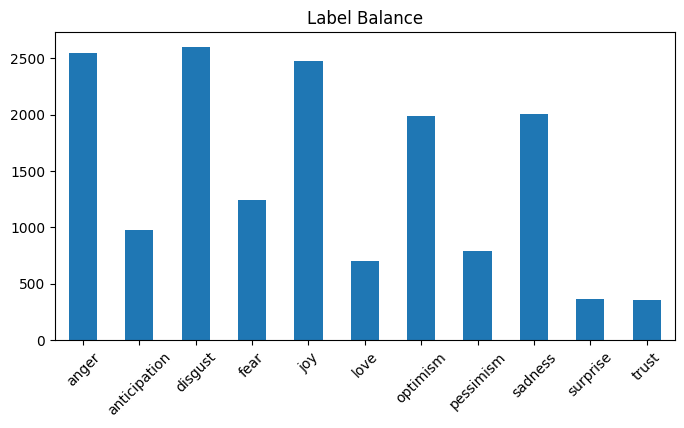

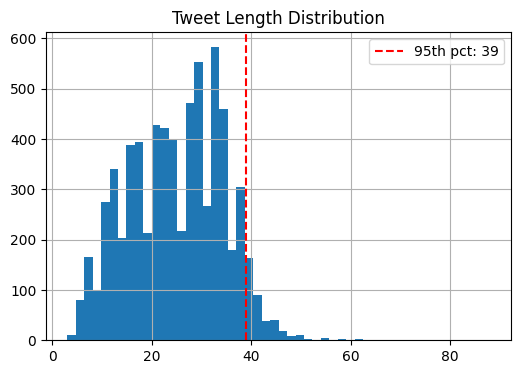

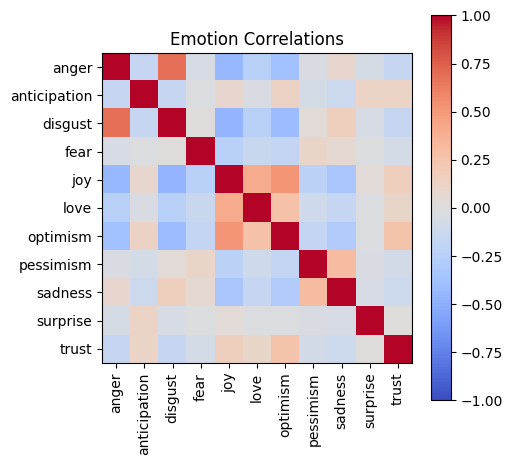

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer

ds   = load_dataset("cardiffnlp/super_tweeteval", "tweet_emotion")["train"]
tok  = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)
labels = ['anger','anticipation','disgust','fear','joy','love','optimism',
          'pessimism','sadness','surprise','trust']

df = pd.DataFrame({
    "text": ds["text"],
    **{ lbl: np.array(ds["gold_label_list"])[:,i] for i,lbl in enumerate(labels) }
})

counts = df[labels].sum()
counts.plot.bar(figsize=(8,4), rot=45, title="Label Balance")
plt.show()

lengths = df["text"].map(lambda t: len(tok.encode(t, truncation=False)))
p95 = int(lengths.quantile(0.95))
lengths.hist(bins=50, figsize=(6,4))
plt.axvline(p95, color="red", linestyle="--", label=f"95th pct: {p95}")
plt.title("Tweet Length Distribution"); plt.legend(); plt.show()

corr = df[labels].corr()
plt.figure(figsize=(5,5))
plt.imshow(corr, vmin=-1, vmax=1, cmap="coolwarm")
plt.xticks(range(len(labels)), labels, rotation=90)
plt.yticks(range(len(labels)), labels)
plt.title("Emotion Correlations"); plt.colorbar(); plt.show()


### **Next Steps**
Based on the findings from the datasets, we proceeded with the following adjustments:

1. **Class-Weighted Loss Implementation**
   - We computed class_weights based on the inverse frequency of each emotion label from the dataset's label counts. This assigns higher importance to less frequent emotions during training.
   - We integrated these class_weights into the BCEWithLogitsLoss function by passing them to the pos_weight parameter. This ensures that the model is penalized more heavily for misclassifying rare emotions.

2. **Custom Trainer for Weighted Loss**

   - Created a custom MyTrainer class that inherits from the Hugging Face Trainer.
   - Overrode the compute_loss method within MyTrainer to utilize the BCEWithLogitsLoss with the calculated class_weights.

3. **Re-Training with Weighted Loss**

   - Re-initialized the Trainer with the custom MyTrainer class, ensuring that the training process now uses the class-weighted loss.
   - Initiated the re-training of the bertweet_two_model using the configured training arguments and datasets.

In [ ]:
import torch
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from torch.nn import BCEWithLogitsLoss
from transformers import Trainer, TrainingArguments 

total_samples = counts.sum()
class_weights = total_samples / (len(labels) * counts)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

class MyTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = BCEWithLogitsLoss(pos_weight=class_weights_tensor.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

bertweet_two_trainer = MyTrainer(
    model=bertweet_two_model,
    args=bertweet_two_training_args,
    train_dataset=bertweet_two_encoded_dataset["train"],
    eval_dataset=bertweet_two_encoded_dataset["validation"],
    tokenizer=bertweet_two_tokenizer,
    data_collator=bertweet_two_data_collator,
    compute_metrics=bertweet_two_compute_metrics
)

bertweet_two_trainer.train()

C:\Users\samabdul\AppData\Local\Temp\ipykernel_16344\2358883485.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)
C:\Users\samabdul\AppData\Local\Temp\ipykernel_16344\2358883485.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `MyTrainer.__init__`. Use `processing_class` instead.
  bertweet_two_trainer = MyTrainer(


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.371500,0.378844,0.451768,0.261851
2,0.354600,0.373567,0.470967,0.266366
3,0.339200,0.361414,0.490380,0.252822
4,0.327600,0.355918,0.556578,0.227991
5,0.313400,0.352483,0.557642,0.238149
6,0.311100,0.350083,0.561794,0.256208
7,0.296000,0.349301,0.571213,0.241535
8,0.293500,0.349308,0.569108,0.229120
9,0.293600,0.348954,0.569296,0.229120
10,0.293300,0.349035,0.568626,0.227991


TrainOutput(global_step=2140, training_loss=0.3185035487201726, metrics={'train_runtime': 7714.4518, 'train_samples_per_second': 8.864, 'train_steps_per_second': 0.277, 'total_flos': 1470149033343600.0, 'train_loss': 0.3185035487201726, 'epoch': 10.0})

In [312]:
bertweet_two_prediction = bertweet_two_trainer.predict(bertweet_two_encoded_dataset["test"])

bertweet_two_test_metrics = bertweet_two_compute_metrics(bertweet_two_prediction)

print("\n Test Set Evaluation Metrics")
print(f" Accuracy: {bertweet_two_test_metrics['accuracy']:.4f}")
print(f" F1-Score (Macro): {bertweet_two_test_metrics['f1']:.4f}")



 Test Set Evaluation Metrics
 Accuracy: 0.2492
 F1-Score (Macro): 0.5574


###  **Conclusion for BERT & SuperTweetEval**

We fine-tuned `vinai/bertweet-base` on the SuperTweetEval emotion dataset. Our initial fine-tuning achieved the following results:

* **Test Accuracy:** 0.0525
* **F1-Score (Macro):** 0.5422

We conducted an exploratory data analysis (EDA) to understand the dataset's characteristics and identify potential challenges. The EDA revealed:

1.  **Class Imbalance:** Emotions like 'disgust,' 'anger,' and 'joy' are significantly more frequent than 'trust,' 'surprise,' and 'love.'
2.  **Tweet Length Distribution:** The majority (95%) of tweets have lengths below 39 tokens.
3.  **Emotion Co-occurrence:** Certain emotions exhibit strong positive correlations (e.g., 'joy' and 'optimism'), while others show weak or negative correlations.

Based on the EDA, we addressed the class imbalance by implementing a weighted loss function.

1.  **Class-Weighted Loss Implementation:** We computed class weights based on the inverse frequency of each emotion label. We also ntegrated these weights into the `BCEWithLogitsLoss` function via the `pos_weight` parameter, increasing the penalty for misclassifying rare emotions.

2.  **Custom Trainer for Weighted Loss:** We created a custom `MyTrainer` class inheriting from the Hugging Face `Trainer` and we overrode the `compute_loss` method to use the weighted `BCEWithLogitsLoss`.

3.  **Re-Training with Weighted Loss:** Lastly we re-initialized the `Trainer` with the `MyTrainer` class, then we re-trained the `bertweet_two_model`.

Re-training with the class-weighted loss yielded the following improved results:

* **Test Accuracy:** 0.2492
* **F1-Score (Macro):** 0.5574

The application of class-weighted loss led to a significant improvement in test accuracy (from 0.0525 to 0.2492) and a slight improvement in macro-F1 score (from 0.5422 to 0.5574). This demonstrates that addressing the class imbalance in the SuperTweetEval dataset can improve the model's ability to classify emotions, particularly the less frequent ones.



---

## **Overall Conclusion**

This study explored the fine-tuning of transformer-based language models for emotion detection on two Twitter-sourced datasets: **TweetEval** and **SuperTweetEval**. Our objective was to evaluate the effectiveness of domain-adapted language models specifically `bert-base-uncased`, `vinai/bertweet-base`, and `XLM-RoBERTa` in capturing emotional signals from short-form, user-generated text, and to assess how training strategies must be tailored to distinct dataset characteristics.

On the **TweetEval** dataset, which offers a relatively balanced, single-label classification setup, we demonstrated that switching to a **domain-specific pretrained model** (`vinai/bertweet-base`) significantly improved performance. Combined with refined preprocessing, stronger regularization, and advanced optimization techniques (e.g., ultra-low learning rate, cosine scheduling, gradient accumulation), we achieved a **test accuracy of 82.69%** and a **weighted F1-score of 82.64%**. This represents an improvement of over 3 percentage points in both metrics compared to the baseline `bert-base-uncased`, validating the impact of domain-aware model selection and fine-tuning precision.

In contrast, the **SuperTweetEval** dataset introduced more complexity due to its **multi-label classification format**, **high class imbalance**, and **greater label granularity**. Initial fine-tuning results were suboptimal (accuracy: 5.25%, macro-F1: 54.22%), prompting a detailed exploratory data analysis. We found substantial label frequency disparities and co-occurrence patterns that ruined model predictions. To address these challenges, we implemented a **class-weighted loss function** within a custom Hugging Face training loop. This adaptation led to a notable improvement in test accuracy (to 24.92%) and a modest increase in macro-F1 (to 55.74%). These gains indicate that **rebalancing label representation** can substantially enhance model performance, particularly for underrepresented emotional categories.

In summary, our findings highlight the critical importance of **dataset-specific adaptation** in emotion classification tasks. Although pretrained transformer models offer a strong baseline, their effectiveness is highly dependent on thoughtful alignment between model architecture and dataset characteristics, as well as careful design of loss functions and fine-tuning strategies.

Overall, the **TweetEval** dataset yielded superior performance compared to **SuperTweetEval**, largely due to its **single-label classification format**, which simplifies the learning task for the model. In contrast, the **multi-label nature** and **greater class imbalance** of SuperTweetEval posed additional challenges, requiring more sophisticated handling to achieve meaningful performance gains.